Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [10]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib notebook

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

**I already did this in the previous notebook**

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    
  regul_param = tf.placeholder(tf.float32, shape=() )
  
  # Variables.
  numhidden = 64
  weights0 = tf.Variable(tf.truncated_normal([image_size * image_size, numhidden]))
  biases0 = tf.Variable(tf.zeros([numhidden]))

  weights1 = tf.Variable(tf.truncated_normal([numhidden, num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))
  
  # Compute hidden layer activations computation.
  logits = tf.matmul(tf_train_dataset, weights0) + biases0
  activations0 = tf.nn.relu(logits)

  #Compute logits
  logits = tf.matmul(activations0, weights1) + biases1
  
  #loss function without regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  #loss funtion with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) +\
            regul_param*tf.nn.l2_loss(weights0) +\
            regul_param*tf.nn.l2_loss(weights1) +\
            regul_param*tf.nn.l2_loss(biases0) +\
            regul_param*tf.nn.l2_loss(biases1)
  
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_prediction = tf.matmul(tf_valid_dataset, weights0) + biases0
  valid_prediction = tf.nn.relu(valid_prediction)
  valid_prediction = tf.matmul(valid_prediction, weights1) + biases1
  valid_prediction = tf.nn.softmax(valid_prediction)
    
  test_prediction = tf.matmul(tf_test_dataset, weights0) + biases0
  test_prediction = tf.nn.relu(test_prediction)
  test_prediction = tf.matmul(test_prediction, weights1) + biases1
  test_prediction = tf.nn.softmax(test_prediction)

In [6]:
num_steps = 3001

batch_accs = []
valid_accs = []
numsteps = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data,
                 tf_train_labels : batch_labels,
                 regul_param: 0.0} #l2-regularization parameter
    xx, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 200 == 0):
      batch_accs.append(accuracy(predictions, batch_labels))
      valid_accs.append(accuracy(valid_prediction.eval(), valid_labels))
      numsteps.append(step)
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 68.194153
Minibatch accuracy: 14.8%
Validation accuracy: 29.4%
Minibatch loss at step 200: 2.178960
Minibatch accuracy: 63.3%
Validation accuracy: 70.4%
Minibatch loss at step 400: 1.270866
Minibatch accuracy: 74.2%
Validation accuracy: 74.5%
Minibatch loss at step 600: 1.656111
Minibatch accuracy: 71.1%
Validation accuracy: 73.2%
Minibatch loss at step 800: 1.071856
Minibatch accuracy: 75.0%
Validation accuracy: 74.5%
Minibatch loss at step 1000: 0.975229
Minibatch accuracy: 78.1%
Validation accuracy: 75.6%
Minibatch loss at step 1200: 0.784546
Minibatch accuracy: 75.0%
Validation accuracy: 76.8%
Minibatch loss at step 1400: 0.786512
Minibatch accuracy: 83.6%
Validation accuracy: 77.5%
Minibatch loss at step 1600: 0.849480
Minibatch accuracy: 78.9%
Validation accuracy: 77.8%
Minibatch loss at step 1800: 0.987264
Minibatch accuracy: 79.7%
Validation accuracy: 78.7%
Minibatch loss at step 2000: 0.732461
Minibatch accuracy: 82.0%
Validation accuracy:

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [7]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    
  regul_param = tf.placeholder(tf.float32, shape=() )
  keep_prob   = tf.placeholder(tf.float32, shape=() )
  
  # Variables.
  numhidden = 64
  weights0 = tf.Variable(tf.truncated_normal([image_size * image_size, numhidden]))
  biases0 = tf.Variable(tf.zeros([numhidden]))

  weights1 = tf.Variable(tf.truncated_normal([numhidden, num_labels]))
  biases1 = tf.Variable(tf.zeros([num_labels]))
  
  # Compute hidden layer activations computation.
  logits = tf.matmul(tf_train_dataset, weights0) + biases0
  activations0 = tf.nn.relu(logits)
    
  #apply dropout
  activations0=tf.nn.dropout(x=activations0,keep_prob=keep_prob,seed=12)

  #Compute logits
  logits = tf.matmul(activations0, weights1) + biases1
  
  
  #loss function without regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  #loss funtion with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) +\
            regul_param*tf.nn.l2_loss(weights0) +\
            regul_param*tf.nn.l2_loss(weights1) +\
            regul_param*tf.nn.l2_loss(biases0) +\
            regul_param*tf.nn.l2_loss(biases1)
  
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_prediction = tf.matmul(tf_valid_dataset, weights0) + biases0
  valid_prediction = tf.nn.relu(valid_prediction)
  valid_prediction = tf.matmul(valid_prediction, weights1) + biases1
  valid_prediction = tf.nn.softmax(valid_prediction)
    
  test_prediction = tf.matmul(tf_test_dataset, weights0) + biases0
  test_prediction = tf.nn.relu(test_prediction)
  test_prediction = tf.matmul(test_prediction, weights1) + biases1
  test_prediction = tf.nn.softmax(test_prediction)

## Optimizing the dropout probability using the already optimized l2-regularizer

In [8]:
num_steps = 3001

batch_accs = []
valid_accs = []
test_accs = []
keepprobs = np.linspace(0.1,0.9,10)

with tf.Session(graph=graph) as session:
    
  for keepprob in keepprobs:
      print("Keep prob:",keepprob)
      tf.global_variables_initializer().run()
      print("Initialized")
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data,
                     tf_train_labels : batch_labels,
                     regul_param: 1e-3,
                     keep_prob: keepprob} #l2-regularization parameter
        xx, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
 
      batch_accs.append(accuracy(predictions, batch_labels))
      valid_accs.append(accuracy(valid_prediction.eval(), valid_labels))
      test_accs.append(accuracy(test_prediction.eval(), test_labels))
      print("  batch accuracy:",batch_accs[-1])
      print("  valid accuracy:",valid_accs[-1])
      print("  test  accuracy:",test_accs[-1])

Keep prob: 0.1
Initialized
  batch accuracy: 30.46875
  valid accuracy: 61.91
  test  accuracy: 68.15
Keep prob: 0.188888888889
Initialized
  batch accuracy: 58.59375
  valid accuracy: 79.22
  test  accuracy: 86.67
Keep prob: 0.277777777778
Initialized
  batch accuracy: 77.34375
  valid accuracy: 80.83
  test  accuracy: 87.72
Keep prob: 0.366666666667
Initialized
  batch accuracy: 82.03125
  valid accuracy: 81.23
  test  accuracy: 88.1
Keep prob: 0.455555555556
Initialized
  batch accuracy: 82.03125
  valid accuracy: 83.07
  test  accuracy: 89.87
Keep prob: 0.544444444444
Initialized
  batch accuracy: 85.9375
  valid accuracy: 83.29
  test  accuracy: 89.74
Keep prob: 0.633333333333
Initialized
  batch accuracy: 85.15625
  valid accuracy: 83.26
  test  accuracy: 89.9
Keep prob: 0.722222222222
Initialized
  batch accuracy: 82.8125
  valid accuracy: 83.78
  test  accuracy: 90.07
Keep prob: 0.811111111111
Initialized
  batch accuracy: 83.59375
  valid accuracy: 83.86
  test  accuracy: 90.3

<IPython.core.display.Javascript object>


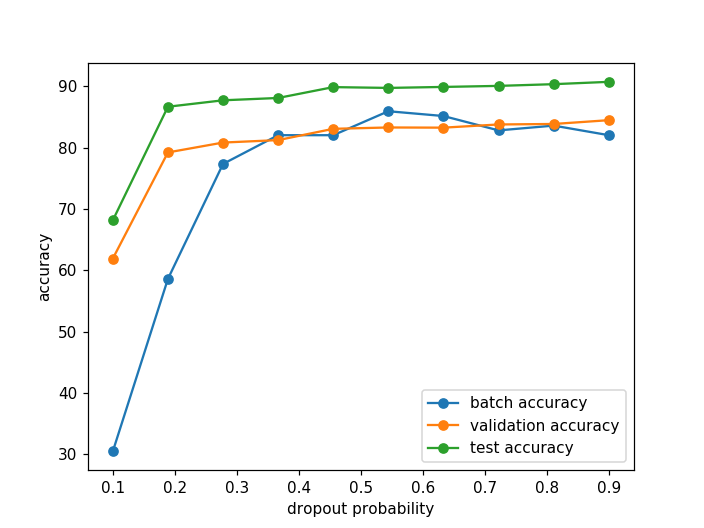

In [11]:
plt.figure()
plt.plot(keepprobs,batch_accs,'-o',label='batch accuracy')
plt.plot(keepprobs,valid_accs,'-o',label='validation accuracy')
plt.plot(keepprobs,test_accs,'-o' ,label='test accuracy')
plt.xlabel('dropout probability')
plt.ylabel('accuracy')
plt.legend()

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [12]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size * image_size))
  tf_train_labels  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset  = tf.constant(test_dataset)
    
  regul_param = tf.placeholder(tf.float32, shape=() )
  keep_prob   = tf.placeholder(tf.float32, shape=() )
  
  # Variables.
  numhidden0 = 128
  weights0 = tf.Variable(tf.truncated_normal([image_size * image_size, numhidden0]))
  biases0 = tf.Variable(tf.zeros([numhidden0]))

  numhidden1 = 32
  weights1 = tf.Variable(tf.truncated_normal([numhidden0, numhidden1]))
  biases1 = tf.Variable(tf.zeros([numhidden1]))
    
  weights2 = tf.Variable(tf.truncated_normal([numhidden1, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
    
  activation0 = tf.nn.relu(tf.matmul(tf_train_dataset, weights0) + biases0)
  activation1 = tf.nn.relu(tf.matmul(activation0, weights1) + biases1)

  #Compute logits
  logits = tf.matmul(activation1, weights2) + biases2
  
  #loss function without regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  #loss funtion with regularization
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) +\
            regul_param*tf.nn.l2_loss(weights0) +\
            regul_param*tf.nn.l2_loss(weights1) +\
            regul_param*tf.nn.l2_loss(biases0) +\
            regul_param*tf.nn.l2_loss(biases1)
  
  
  # Optimizer.
  ###optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(loss)
  optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
    
  valid_prediction = tf.matmul(tf_valid_dataset, weights0) + biases0
  valid_prediction = tf.nn.relu(valid_prediction)
  valid_prediction = tf.matmul(valid_prediction, weights1) + biases1
  valid_prediction = tf.nn.relu(valid_prediction)
  valid_prediction = tf.matmul(valid_prediction, weights2) + biases2
  valid_prediction = tf.nn.softmax(valid_prediction)
    
  test_prediction = tf.matmul(tf_test_dataset, weights0) + biases0
  test_prediction = tf.nn.relu(test_prediction)
  test_prediction = tf.matmul(test_prediction, weights1) + biases1
  test_prediction = tf.nn.relu(test_prediction)
  test_prediction = tf.matmul(test_prediction, weights2) + biases2
  test_prediction = tf.nn.softmax(test_prediction)

In [13]:
num_steps = 40001

batch_accs = []
valid_accs = []
numsteps = []

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
  ###for step in range(2001):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data,
                 tf_train_labels : batch_labels,
                 regul_param: 1e-3} #l2-regularization parameter
    xx, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2000 == 0):
      print("step:",step)
      batch_accs.append(accuracy(predictions, batch_labels))
      valid_accs.append(accuracy(valid_prediction.eval(), valid_labels))
      numsteps.append(step)
      print("  Minibatch loss at step %d: %f" % (step, l))
      print("  Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("  Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
      print("  Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  test_preds=test_prediction.eval()

Initialized
step: 0
  Minibatch loss at step 0: 366.988770
  Minibatch accuracy: 15.6%
  Validation accuracy: 14.4%
  Test accuracy: 14.7%
step: 2000
  Minibatch loss at step 2000: 38.167728
  Minibatch accuracy: 39.8%
  Validation accuracy: 39.4%
  Test accuracy: 44.7%
step: 4000
  Minibatch loss at step 4000: 26.992136
  Minibatch accuracy: 60.9%
  Validation accuracy: 59.7%
  Test accuracy: 66.9%
step: 6000
  Minibatch loss at step 6000: 14.191782
  Minibatch accuracy: 68.0%
  Validation accuracy: 69.8%
  Test accuracy: 77.7%
step: 8000
  Minibatch loss at step 8000: 5.729410
  Minibatch accuracy: 75.8%
  Validation accuracy: 75.8%
  Test accuracy: 83.4%
step: 10000
  Minibatch loss at step 10000: 2.211069
  Minibatch accuracy: 82.8%
  Validation accuracy: 81.4%
  Test accuracy: 88.7%
step: 12000
  Minibatch loss at step 12000: 1.122879
  Minibatch accuracy: 84.4%
  Validation accuracy: 84.0%
  Test accuracy: 90.8%
step: 14000
  Minibatch loss at step 14000: 0.715115
  Minibatch acc

## Visualize some of the mislabeled data

In [14]:
test_preds
diff=np.argmax(test_preds, axis=1)-np.argmax(test_labels, axis=1)
diffindex=np.nonzero(diff)

<IPython.core.display.Javascript object>


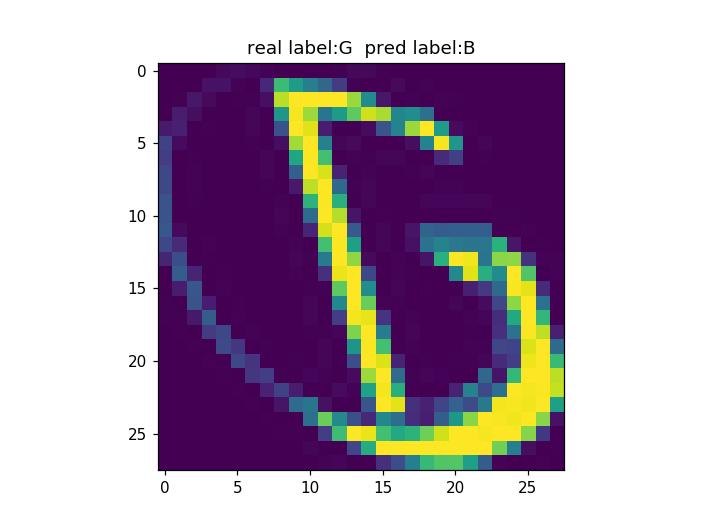

In [15]:
letters=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

index=np.random.choice(diffindex[0])

plt.figure()
plt.title('real label:'+letters[np.argmax(test_labels, axis=1)[index]]+'  '+\
          'pred label:'+letters[np.argmax(test_preds, axis=1)[index]])
plt.imshow(test_dataset[index,:].reshape((28,28)) )

<IPython.core.display.Javascript object>


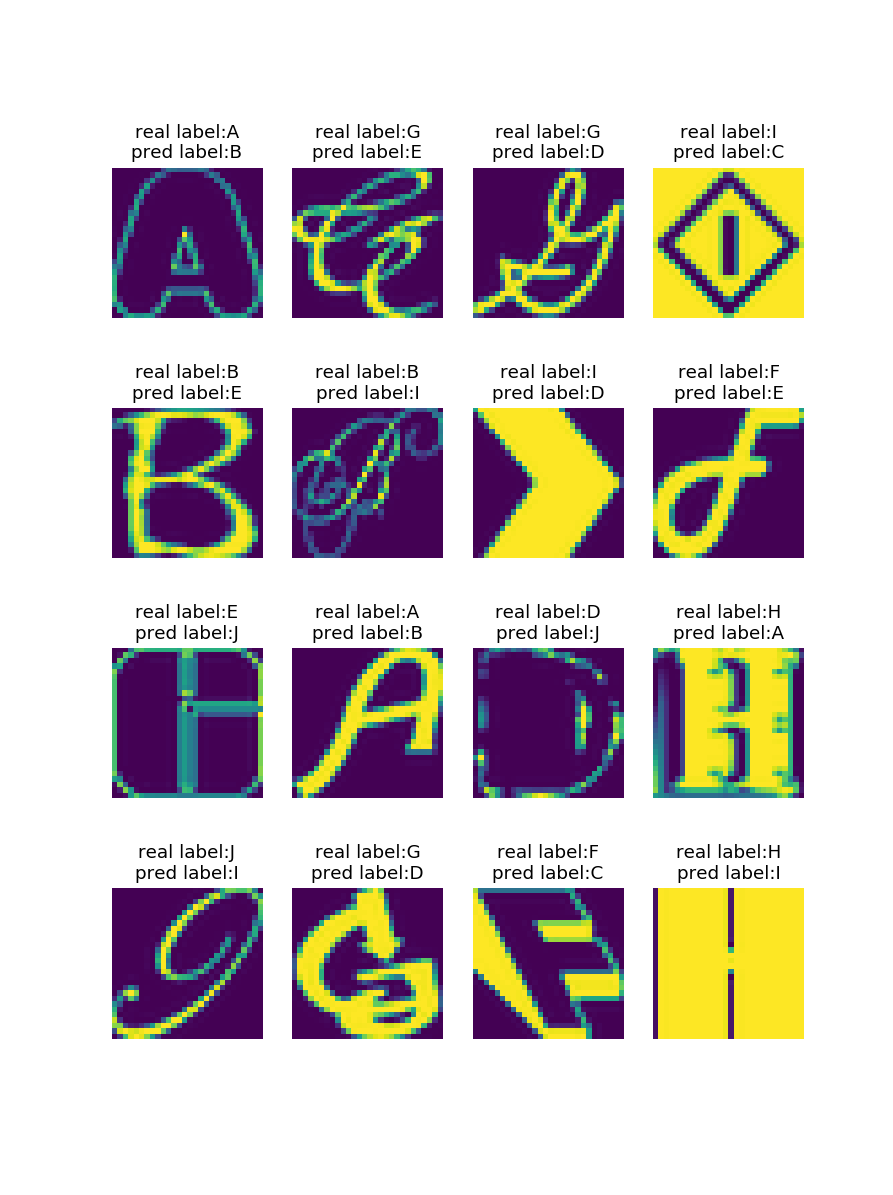

In [16]:
plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    index=np.random.choice(diffindex[0])
    plt.imshow(test_dataset[index,:].reshape((28,28)) )
    plt.axis('off')
    plt.gca().set_title('real label:'+letters[np.argmax(test_labels, axis=1)[index]]+'\n'+\
              'pred label:'+letters[np.argmax(test_preds, axis=1)[index]])